In [1]:
# Carregamento e preparação dos dados
import pandas as pd
import random
import matplotlib.pyplot as plt

# Carrega dataset de alimentos
df_alimentos = pd.read_csv("alimentos.csv")
df_alimentos.fillna(0, inplace=True)

print(f"Dataset carregado: {len(df_alimentos)} alimentos")
print(f"Colunas: {list(df_alimentos.columns)}")

Dataset carregado: 597 alimentos
Colunas: ['Número do Alimento', 'Categoria do alimento', 'Descrição dos alimentos', 'Umidade....', 'Energia..kcal.', 'Energia..kJ.', 'Proteína..g.', 'Lipídeos..g.', 'Colesterol..mg.', 'Carboidrato..g.', 'Fibra.Alimentar..g.', 'Cinzas..g.', 'Cálcio..mg.', 'Magnésio..mg.', 'Manganês..mg.', 'Fósforo..mg.', 'Ferro..mg.', 'Sódio..mg.', 'Potássio..mg.', 'Cobre..mg.', 'Zinco..mg.', 'Retinol..mcg.', 'RE..mcg.', 'RAE..mcg.', 'Tiamina..mg.', 'Riboflavina..mg.', 'Piridoxina..mg.', 'Niacina..mg.', 'Vitamina.C..mg.']


In [2]:
# =============================================================================
# CONFIGURAÇÕES GLOBAIS DO EXPERIMENTO
# =============================================================================

# Parâmetros do algoritmo genético
CONFIG = {
    # População e evolução
    "tamanho_populacao": 30,
    "num_geracoes": 1000,
    "num_elitistas": 2,
    "seed_random": 42,
    
    # Parâmetros de mutação
    "taxa_mutacao": 0.1,
    
    # Parâmetros de seleção
    "tamanho_torneio": 3,
    
    # Metas nutricionais diárias
    "metas_nutricionais": {
        "Energia..kcal.": 2000,
        "Proteína..g.": 75,
        "Carboidrato..g.": 275,
        "Lipídeos..g.": 70,
    }
}

print("=== CONFIGURAÇÕES DO EXPERIMENTO ===")
print(f"População: {CONFIG['tamanho_populacao']} indivíduos")
print(f"Gerações: {CONFIG['num_geracoes']}")
print(f"Elitistas: {CONFIG['num_elitistas']}")
print(f"Taxa mutação: {CONFIG['taxa_mutacao']}")
print(f"Seed: {CONFIG['seed_random']}")

print(f"\nMetas nutricionais:")
for nutriente, meta in CONFIG["metas_nutricionais"].items():
    print(f"  {nutriente}: {meta}")


random.seed(CONFIG["seed_random"])  # Para reprodutibilidade

=== CONFIGURAÇÕES DO EXPERIMENTO ===
População: 30 indivíduos
Gerações: 1000
Elitistas: 2
Taxa mutação: 0.1
Seed: 42

Metas nutricionais:
  Energia..kcal.: 2000
  Proteína..g.: 75
  Carboidrato..g.: 275
  Lipídeos..g.: 70


In [3]:
def gerar_cardapio_aleatorio(df):
    """Gera um cardápio aleatório com 3 refeições (café, almoço, jantar)"""
    alimentos = df["Descrição dos alimentos"].dropna().unique().tolist()

    cardapio = {
        "cafe": random.sample(alimentos, k=random.randint(2, 3)),
        "almoco": random.sample(alimentos, k=random.randint(2, 3)),
        "jantar": random.sample(alimentos, k=random.randint(2, 3)),
    }

    return cardapio

In [4]:
# Gerar população inicial comum para comparação justa
print(f"\nGerando população inicial comum ({CONFIG['tamanho_populacao']} indivíduos)...")
populacao_inicial = [gerar_cardapio_aleatorio(df_alimentos) for _ in range(CONFIG["tamanho_populacao"])]
print("✅ População inicial gerada")


Gerando população inicial comum (30 indivíduos)...
✅ População inicial gerada


In [5]:
def calcular_nutrientes_cardapio(cardapio, df):
    """Calcula o total de nutrientes de um cardápio"""
    total = {
        "Energia..kcal.": 0,
        "Proteína..g.": 0,
        "Carboidrato..g.": 0,
        "Lipídeos..g.": 0,
    }

    for refeicao, alimentos in cardapio.items():
        for alimento in alimentos:
            dados = df[df["Descrição dos alimentos"] == alimento]
            if not dados.empty:
                for chave in total.keys():
                    valor = dados[chave].values[0]
                    if pd.notna(valor):
                        total[chave] += valor

    return total

In [6]:
def calcular_fitness(nutrientes, metas):
    """Calcula fitness: quanto menor o desvio das metas, melhor"""
    fitness = 0

    for chave in metas.keys():
        valor_real = nutrientes.get(chave, 0)
        valor_meta = metas[chave]
        desvio = abs(valor_real - valor_meta)
        fitness -= desvio  # Penaliza desvios

    return fitness

In [7]:
def selecao_por_torneio(populacao, fitnesses):
    """Seleção por torneio: escolhe o melhor entre k indivíduos aleatórios"""
    k = CONFIG["tamanho_torneio"]
    selecionados = []

    for _ in range(len(populacao)):
        participantes = random.sample(list(zip(populacao, fitnesses)), k)
        vencedor = max(participantes, key=lambda x: x[1])
        selecionados.append(vencedor[0])

    return selecionados

In [8]:
def crossover(card1, card2):
    """Crossover: escolhe aleatoriamente cada refeição de um dos pais"""
    filho = {}

    for refeicao in ["cafe", "almoco", "jantar"]:
        filho[refeicao] = random.choice([card1[refeicao], card2[refeicao]])

    return filho

In [9]:
def mutacao_refeicao_completa(cardapio, df):
    """Mutação básica: troca uma refeição inteira (alta variação)"""
    taxa = CONFIG["taxa_mutacao"]
    novo = {ref: list(itens) for ref, itens in cardapio.items()}
    alimentos_possiveis = df["Descrição dos alimentos"].dropna().unique().tolist()

    for refeicao in novo:
        if random.random() < taxa:
            # Substitui a refeição inteira
            novo[refeicao] = random.sample(alimentos_possiveis, 
                                         k=random.randint(2, 3))

    return novo

In [10]:
def algoritmo_genetico_basico(df, populacao_inicial=None):
    """Algoritmo genético básico sem elitismo"""
    metas = CONFIG["metas_nutricionais"]
    geracoes = CONFIG["num_geracoes"]
    N = CONFIG["tamanho_populacao"]
    
    if populacao_inicial is not None:
        # Deep copy da população inicial
        populacao = [{ref: list(itens) for ref, itens in cardapio.items()} 
                    for cardapio in populacao_inicial]
    else:
        populacao = [gerar_cardapio_aleatorio(df) for _ in range(N)]
    
    fitness_max_evolucao = []
    fitness_medio_evolucao = []

    for g in range(geracoes):
        # Avalia população
        fitnesses = [
            calcular_fitness(calcular_nutrientes_cardapio(c, df), metas)
            for c in populacao
        ]

        fitness_max_evolucao.append(max(fitnesses))
        fitness_medio_evolucao.append(sum(fitnesses) / len(fitnesses))

        # Seleção, crossover e mutação
        selecionados = selecao_por_torneio(populacao, fitnesses)
        nova_populacao = []
        
        for i in range(0, N, 2):
            pai1 = selecionados[i]
            pai2 = selecionados[i + 1 if i + 1 < N else 0]
            filho1 = crossover(pai1, pai2)
            filho2 = crossover(pai2, pai1)
            nova_populacao.extend([
                mutacao_refeicao_completa(filho1, df), 
                mutacao_refeicao_completa(filho2, df)
            ])

        populacao = nova_populacao[:N]

    # Retorna o melhor
    fitnesses = [
        calcular_fitness(calcular_nutrientes_cardapio(c, df), metas) 
        for c in populacao
    ]
    melhor_idx = fitnesses.index(max(fitnesses))

    return (
        populacao[melhor_idx],
        fitnesses[melhor_idx],
        fitness_max_evolucao,
        fitness_medio_evolucao,
    )

In [11]:
# Análise da população inicial comum
print("\n=== ANÁLISE DA POPULAÇÃO INICIAL COMUM ===")
fitnesses_iniciais = [
    calcular_fitness(calcular_nutrientes_cardapio(c, df_alimentos), CONFIG["metas_nutricionais"])
    for c in populacao_inicial
]
melhor_fitness_inicial = max(fitnesses_iniciais)
fitness_medio_inicial = sum(fitnesses_iniciais) / len(fitnesses_iniciais)
print(f"Melhor fitness inicial: {melhor_fitness_inicial:.1f}")
print(f"Fitness médio inicial: {fitness_medio_inicial:.1f}")

# FASE 1: Algoritmo Genético Básico
print("\n=== FASE 1: ALGORITMO GENÉTICO BÁSICO ===")
print("Problema: Mutação troca refeições inteiras, causando alta variação no fitness")
print("Usando população inicial comum para comparação justa...")

melhor_cardapio_basico, melhor_fitness_basico, fit_max_basico, fit_med_basico = algoritmo_genetico_basico(
    df_alimentos, populacao_inicial=populacao_inicial
)

print("\nMelhor cardápio encontrado:")
for refeicao, itens in melhor_cardapio_basico.items():
    print(f"  {refeicao.title()}: {'; '.join(itens)}")

nutrientes_basico = calcular_nutrientes_cardapio(melhor_cardapio_basico, df_alimentos)
print(f"\nNutrientes obtidos vs Metas:")
for nutriente, valor in nutrientes_basico.items():
    meta = CONFIG["metas_nutricionais"][nutriente]
    desvio = abs(valor - meta)
    print(f"  {nutriente}: {valor:.1f} (meta: {meta}, desvio: {desvio:.1f})")

print(f"\nFitness final: {melhor_fitness_basico:.2f}")


=== ANÁLISE DA POPULAÇÃO INICIAL COMUM ===
Melhor fitness inicial: -152.6
Fitness médio inicial: -982.2

=== FASE 1: ALGORITMO GENÉTICO BÁSICO ===
Problema: Mutação troca refeições inteiras, causando alta variação no fitness
Usando população inicial comum para comparação justa...

Melhor cardápio encontrado:
  Cafe: Farinha, de trigo; Espinafre, Nova Zelândia, refogado; Carne, bovina, picanha, com gordura, grelhada
  Almoco: Pastel, de carne, frito; Brócolis, cru; Torrada, pão francês
  Jantar: Geléia, mocotó, natural; Pastel, de carne, frito

Nutrientes obtidos vs Metas:
  Energia..kcal.: 2000.0 (meta: 2000, desvio: 0.0)
  Proteína..g.: 75.3 (meta: 75, desvio: 0.3)
  Carboidrato..g.: 269.7 (meta: 275, desvio: 5.3)
  Lipídeos..g.: 70.2 (meta: 70, desvio: 0.2)

Fitness final: -5.80


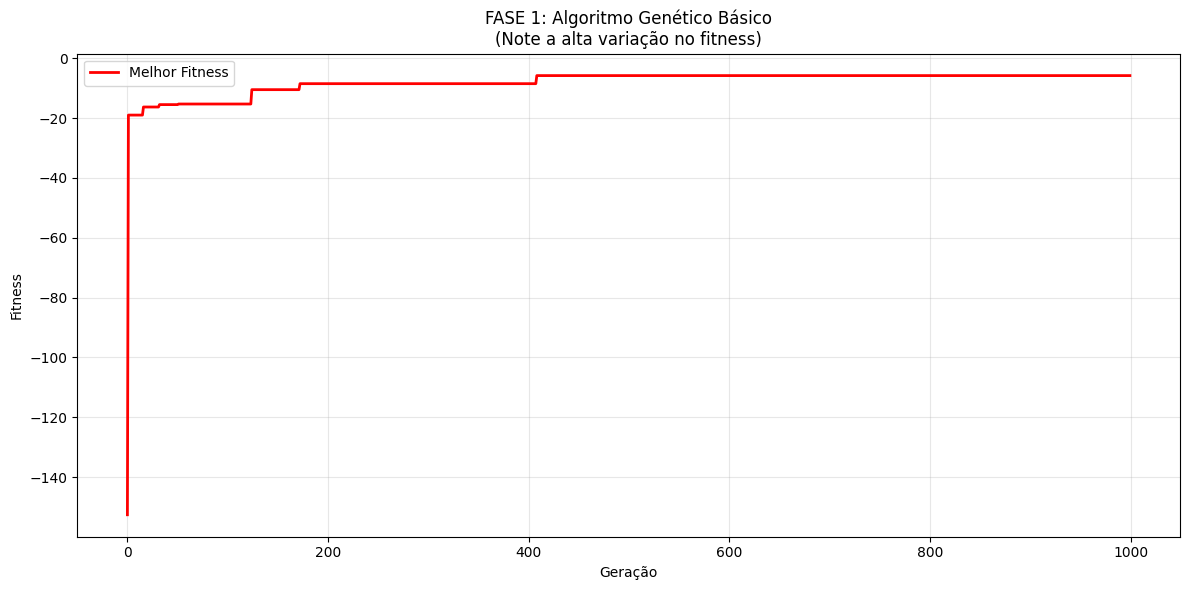

In [12]:
# Visualização do algoritmo básico
plt.figure(figsize=(12, 6))
plt.plot(fit_max_basico, label="Melhor Fitness", linewidth=2, color='red')
plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.title("FASE 1: Algoritmo Genético Básico\n(Note a alta variação no fitness)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
def algoritmo_genetico_com_elitismo(df, populacao_inicial=None):
    """Algoritmo genético com elitismo: preserva os melhores indivíduos"""
    metas = CONFIG["metas_nutricionais"]
    geracoes = CONFIG["num_geracoes"]
    N = CONFIG["tamanho_populacao"]
    num_elitistas = CONFIG["num_elitistas"]
    
    # Inicializa população
    if populacao_inicial is not None:
        populacao = [{ref: list(itens) for ref, itens in cardapio.items()} 
                    for cardapio in populacao_inicial]
    else:
        populacao = [gerar_cardapio_aleatorio(df) for _ in range(N)]

    fitness_max_evolucao = []
    fitness_medio_evolucao = []

    for g in range(geracoes):
        fitnesses = [calcular_fitness(calcular_nutrientes_cardapio(c, df), metas) for c in populacao]
        
        fitness_max_evolucao.append(max(fitnesses))
        fitness_medio_evolucao.append(sum(fitnesses) / len(fitnesses))

        # ELITISMO: preserva os melhores
        elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)[:num_elitistas]
        elite = [populacao[i] for i in elite_indices]

        nova_populacao = elite.copy()
        selecionados = selecao_por_torneio(populacao, fitnesses)

        while len(nova_populacao) < N:
            i = random.randint(0, len(selecionados) - 1)
            j = random.randint(0, len(selecionados) - 1)
            pai1 = selecionados[i]
            pai2 = selecionados[j]
            filho1 = crossover(pai1, pai2)
            filho2 = crossover(pai2, pai1)
            nova_populacao.append(mutacao_refeicao_completa(filho1, df))
            if len(nova_populacao) < N:
                nova_populacao.append(mutacao_refeicao_completa(filho2, df))

        populacao = nova_populacao

    # Retorna o melhor indivíduo
    fitnesses = [calcular_fitness(calcular_nutrientes_cardapio(c, df), metas) for c in populacao]
    melhor_idx = fitnesses.index(max(fitnesses))
    
    return (
        populacao[melhor_idx],
        fitnesses[melhor_idx],
        fitness_max_evolucao,
        fitness_medio_evolucao,
    )

In [14]:
# FASE 2: Algoritmo Genético com Elitismo
print("\n=== FASE 2: ALGORITMO GENÉTICO COM ELITISMO ===")
print("Solução: Preservar os melhores indivíduos a cada geração")
print("Usando a mesma população inicial...")

melhor_cardapio_elitismo, melhor_fitness_elitismo, fit_max_elitismo, fit_med_elitismo = algoritmo_genetico_com_elitismo(
    df_alimentos, populacao_inicial=populacao_inicial
)

print("\nMelhor cardápio encontrado:")
for refeicao, itens in melhor_cardapio_elitismo.items():
    print(f"  {refeicao.title()}: {'; '.join(itens)}")

nutrientes_elitismo = calcular_nutrientes_cardapio(melhor_cardapio_elitismo, df_alimentos)
print(f"\nNutrientes obtidos vs Metas:")
for nutriente, valor in nutrientes_elitismo.items():
    meta = CONFIG["metas_nutricionais"][nutriente]
    desvio = abs(valor - meta)
    print(f"  {nutriente}: {valor:.1f} (meta: {meta}, desvio: {desvio:.1f})")

print(f"\nFitness final: {melhor_fitness_elitismo:.2f}")

# Verificação do elitismo
fitness_decresceu = any(fit_max_elitismo[i] < fit_max_elitismo[i-1] for i in range(1, len(fit_max_elitismo)))
print(f"Elitismo funcionando: {not fitness_decresceu} (fitness nunca diminui)")


=== FASE 2: ALGORITMO GENÉTICO COM ELITISMO ===
Solução: Preservar os melhores indivíduos a cada geração
Usando a mesma população inicial...

Melhor cardápio encontrado:
  Cafe: Feijão, rajado, cru; Cocada branca; Tomate, molho industrializado
  Almoco: Pão, de soja; Azeitona, verde, conserva; Tapioca, com manteiga
  Jantar: Peru, congelado, assado; Frango, inteiro, com pele, cru

Nutrientes obtidos vs Metas:
  Energia..kcal.: 1996.0 (meta: 2000, desvio: 4.0)
  Proteína..g.: 74.7 (meta: 75, desvio: 0.3)
  Carboidrato..g.: 276.2 (meta: 275, desvio: 1.2)
  Lipídeos..g.: 67.4 (meta: 70, desvio: 2.6)

Fitness final: -8.10
Elitismo funcionando: True (fitness nunca diminui)


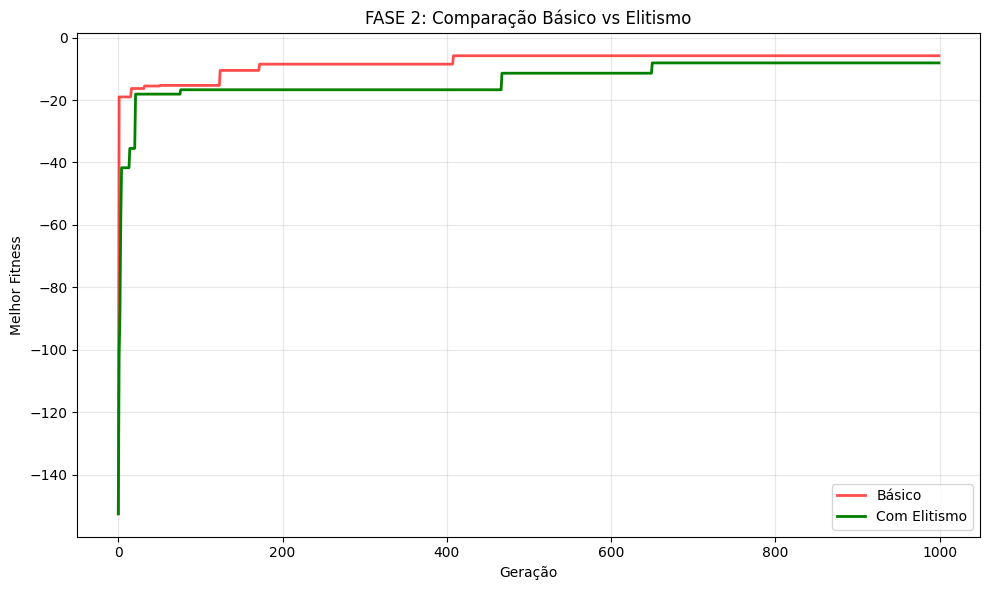

In [15]:
# Visualização da fase 2: elitismo vs básico
plt.figure(figsize=(10, 6))
plt.plot(fit_max_basico, label="Básico", linewidth=2, color='red', alpha=0.7)
plt.plot(fit_max_elitismo, label="Com Elitismo", linewidth=2, color='green')
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.title("FASE 2: Comparação Básico vs Elitismo")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
def mutacao_um_alimento(cardapio, df):
    """Mutação refinada: troca apenas um alimento por vez (pequenas melhorias)"""
    taxa = CONFIG["taxa_mutacao"]
    novo = {ref: list(itens) for ref, itens in cardapio.items()}
    alimentos_possiveis = df["Descrição dos alimentos"].dropna().unique().tolist()

    if random.random() < taxa:
        # Escolhe uma refeição aleatória
        refeicao = random.choice(list(novo.keys()))
        if novo[refeicao]:
            # Troca apenas UM alimento da refeição
            idx = random.randint(0, len(novo[refeicao]) - 1)
            alimento_substituto = random.choice(alimentos_possiveis)
            novo[refeicao][idx] = alimento_substituto

    return novo

In [17]:
def algoritmo_genetico_refinado(df, populacao_inicial=None):
    """Algoritmo genético com elitismo e mutação refinada"""
    metas = CONFIG["metas_nutricionais"]
    geracoes = CONFIG["num_geracoes"]
    N = CONFIG["tamanho_populacao"]
    num_elitistas = CONFIG["num_elitistas"]
    
    # Inicializa população
    if populacao_inicial is not None:
        populacao = [{ref: list(itens) for ref, itens in cardapio.items()} 
                    for cardapio in populacao_inicial]
    else:
        populacao = [gerar_cardapio_aleatorio(df) for _ in range(N)]

    fitness_max_evolucao = []
    fitness_medio_evolucao = []

    for g in range(geracoes):
        fitnesses = [calcular_fitness(calcular_nutrientes_cardapio(c, df), metas) for c in populacao]
        
        fitness_max_evolucao.append(max(fitnesses))
        fitness_medio_evolucao.append(sum(fitnesses) / len(fitnesses))

        # ELITISMO: preserva os melhores
        elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)[:num_elitistas]
        elite = [populacao[i] for i in elite_indices]

        nova_populacao = elite.copy()
        selecionados = selecao_por_torneio(populacao, fitnesses)

        while len(nova_populacao) < N:
            i = random.randint(0, len(selecionados) - 1)
            j = random.randint(0, len(selecionados) - 1)
            pai1 = selecionados[i]
            pai2 = selecionados[j]
            filho1 = crossover(pai1, pai2)
            filho2 = crossover(pai2, pai1)
            nova_populacao.append(mutacao_um_alimento(filho1, df))
            if len(nova_populacao) < N:
                nova_populacao.append(mutacao_um_alimento(filho2, df))

        populacao = nova_populacao

    # Retorna o melhor indivíduo
    fitnesses = [calcular_fitness(calcular_nutrientes_cardapio(c, df), metas) for c in populacao]
    melhor_idx = fitnesses.index(max(fitnesses))
    
    return (
        populacao[melhor_idx],
        fitnesses[melhor_idx],
        fitness_max_evolucao,
        fitness_medio_evolucao,
    )

In [18]:
# FASE 3: Mutação Refinada
print("\n=== FASE 3: MUTAÇÃO REFINADA ===")
print("Melhoria: Trocar apenas um alimento por vez para permitir pequenas melhorias")
print("Usando a mesma população inicial...")

melhor_cardapio_refinado, melhor_fitness_refinado, fit_max_refinado, fit_med_refinado = algoritmo_genetico_refinado(
    df_alimentos, populacao_inicial=populacao_inicial
)

print("\nMelhor cardápio encontrado:")
for refeicao, itens in melhor_cardapio_refinado.items():
    print(f"  {refeicao.title()}: {'; '.join(itens)}")

nutrientes_refinado = calcular_nutrientes_cardapio(melhor_cardapio_refinado, df_alimentos)
print(f"\nNutrientes obtidos vs Metas:")
for nutriente, valor in nutrientes_refinado.items():
    meta = CONFIG["metas_nutricionais"][nutriente]
    desvio = abs(valor - meta)
    print(f"  {nutriente}: {valor:.1f} (meta: {meta}, desvio: {desvio:.1f})")

print(f"\nFitness final: {melhor_fitness_refinado:.2f}")

# Comparação das três abordagens
print(f"\n=== RESUMO COMPARATIVO ===")
print(f"Fitness Inicial:    {melhor_fitness_inicial:.1f} (ponto de partida comum)")
print(f"Fitness Básico:     {melhor_fitness_basico:.1f} (+{melhor_fitness_basico - melhor_fitness_inicial:.1f})")
print(f"Fitness Elitismo:   {melhor_fitness_elitismo:.1f} (+{melhor_fitness_elitismo - melhor_fitness_inicial:.1f})")
print(f"Fitness Refinado:   {melhor_fitness_refinado:.1f} (+{melhor_fitness_refinado - melhor_fitness_inicial:.1f})")

# Melhorias incrementais
print(f"\nMelhorias incrementais:")
print(f"Básico → Elitismo:  +{melhor_fitness_elitismo - melhor_fitness_basico:.1f}")
print(f"Elitismo → Refinado: +{melhor_fitness_refinado - melhor_fitness_elitismo:.1f}")


=== FASE 3: MUTAÇÃO REFINADA ===
Melhoria: Trocar apenas um alimento por vez para permitir pequenas melhorias
Usando a mesma população inicial...

Melhor cardápio encontrado:
  Cafe: Feijão, rajado, cru; Cocada branca; Jamelão, cru
  Almoco: Capuccino, pó; Carne, bovina, paleta, com gordura, crua
  Jantar: Linhaça, semente; Frango, com açafrão

Nutrientes obtidos vs Metas:
  Energia..kcal.: 2000.0 (meta: 2000, desvio: 0.0)
  Proteína..g.: 75.4 (meta: 75, desvio: 0.4)
  Carboidrato..g.: 275.9 (meta: 275, desvio: 0.9)
  Lipídeos..g.: 69.5 (meta: 70, desvio: 0.5)

Fitness final: -1.80

=== RESUMO COMPARATIVO ===
Fitness Inicial:    -152.6 (ponto de partida comum)
Fitness Básico:     -5.8 (+146.8)
Fitness Elitismo:   -8.1 (+144.5)
Fitness Refinado:   -1.8 (+150.8)

Melhorias incrementais:
Básico → Elitismo:  +-2.3
Elitismo → Refinado: +6.3


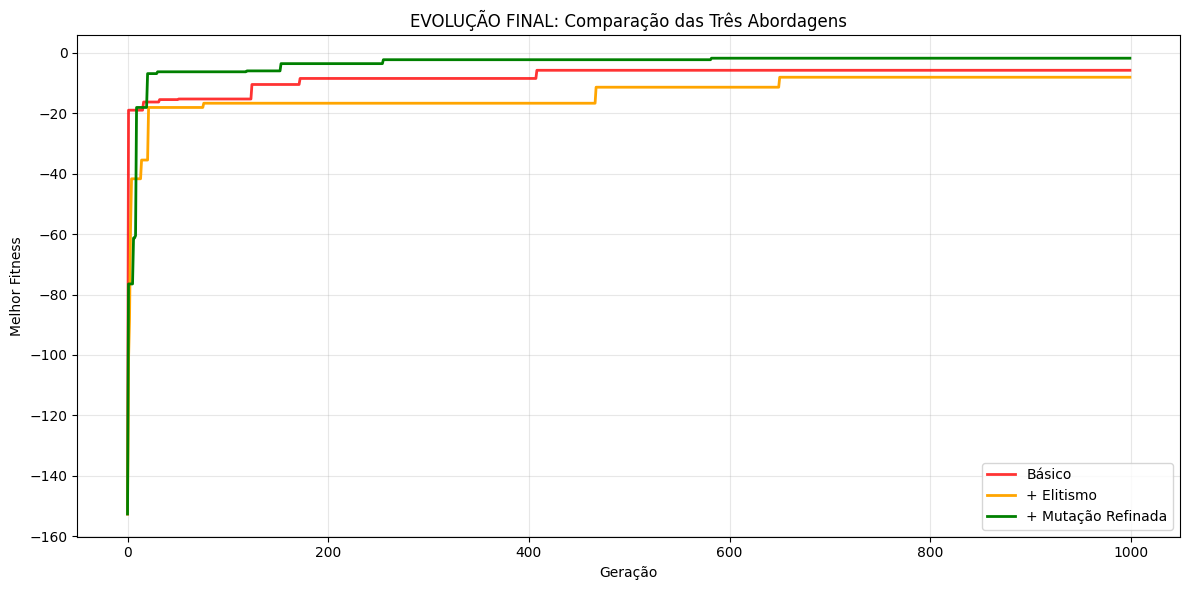

In [19]:
# Visualização final: evolução das três abordagens
plt.figure(figsize=(12, 6))
plt.plot(fit_max_basico, label="Básico", linewidth=2, color='red', alpha=0.8)
plt.plot(fit_max_elitismo, label="+ Elitismo", linewidth=2, color='orange')
plt.plot(fit_max_refinado, label="+ Mutação Refinada", linewidth=2, color='green')
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.title("EVOLUÇÃO FINAL: Comparação das Três Abordagens")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# Análise dos resultados nutricionais finais
print("=== ANÁLISE NUTRICIONAL FINAL ===")
print(f"Melhor resultado obtido com mutação refinada:")

desvio_total = sum(abs(nutrientes_refinado[n] - CONFIG["metas_nutricionais"][n]) for n in CONFIG["metas_nutricionais"].keys())
print(f"Desvio total das metas: {desvio_total:.1f}")

print(f"\nDetalhamento por nutriente:")
for nutriente in CONFIG["metas_nutricionais"].keys():
    valor = nutrientes_refinado[nutriente]
    meta = CONFIG["metas_nutricionais"][nutriente]
    percentual = (valor / meta) * 100
    print(f"  {nutriente:<20}: {percentual:5.1f}% da meta")

print(f"\n=== CONCLUSÕES ===")
print("1. O algoritmo básico apresenta alta variação devido à mutação agressiva")
print("2. O elitismo estabiliza a evolução preservando boas soluções")
print("3. A mutação refinada permite ajustes finos para otimização local")
print("4. A combinação de elitismo + mutação refinada oferece o melhor resultado")

=== ANÁLISE NUTRICIONAL FINAL ===
Melhor resultado obtido com mutação refinada:
Desvio total das metas: 1.8

Detalhamento por nutriente:
  Energia..kcal.      : 100.0% da meta
  Proteína..g.        : 100.5% da meta
  Carboidrato..g.     : 100.3% da meta
  Lipídeos..g.        :  99.3% da meta

=== CONCLUSÕES ===
1. O algoritmo básico apresenta alta variação devido à mutação agressiva
2. O elitismo estabiliza a evolução preservando boas soluções
3. A mutação refinada permite ajustes finos para otimização local
4. A combinação de elitismo + mutação refinada oferece o melhor resultado
